In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, GlobalMaxPooling1D, Dense
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
import random
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [8]:
# Loading the training dataset
df = pd.read_csv('/kaggle/input/llm-train/train (1).csv')

In [9]:
df

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1
1,"The United States is a car-dependent nation, w...",1
2,"In recent years, there has been a growing move...",1
3,"In recent years, there has been a growing move...",1
4,"In the past few decades, the United States has...",1
...,...,...
517184,The whole purpose of democracy is to create a ...,0
517185,I firmly believe that governments worldwide sh...,1
517186,I DFN't agree with this decision because a LFT...,0
517187,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0


In [10]:
df.isna().sum()

text         0
generated    0
dtype: int64

In [11]:
df.duplicated().sum()

124518

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.duplicated().sum()

0

In [14]:
df.drop(517186, inplace=True)

In [15]:
df

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1
1,"The United States is a car-dependent nation, w...",1
2,"In recent years, there has been a growing move...",1
3,"In recent years, there has been a growing move...",1
4,"In the past few decades, the United States has...",1
...,...,...
517183,Tie Face on Mars is really just a big misunder...,0
517184,The whole purpose of democracy is to create a ...,0
517185,I firmly believe that governments worldwide sh...,1
517187,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0


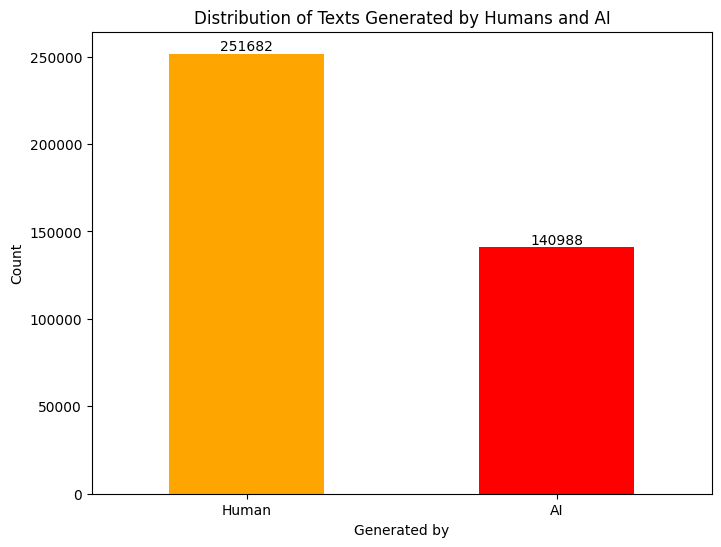

In [16]:
counts = df['generated'].value_counts()
# Plotting the counts
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['orange', 'red'])
plt.title('Distribution of Texts Generated by Humans and AI')
plt.xlabel('Generated by')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'AI'], rotation=0)
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [20]:
df.head(5)

,text,generated
0,## the advantages of limiting car usage\n\nin ...,1
1,"the united states is a car-dependent nation, w...",1
2,"in recent years, there has been a growing move...",1
3,"in recent years, there has been a growing move...",1
4,"in the past few decades, the united states has...",1


In [21]:
# Remove special characters, punctuation, and symbols from each text in the Series
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [22]:
# Get English stopwords
stop_words = set(stopwords.words('english'))
# Remove stopwords from each text in the Series
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [23]:
df.head()

,text,generated
0,advantages limiting car usage recent years gro...,1
1,united states cardependent nation twothirds tr...,1
2,recent years growing movement limit car usage ...,1
3,recent years growing movement limit car usage ...,1
4,past decades united states become increasingly...,1


In [24]:
df.duplicated().sum()

31120

In [25]:
df.drop_duplicates(inplace=True)

In [26]:
df.duplicated().sum()

0

In [27]:
df.isna().sum()

text         0
generated    0
dtype: int64

In [28]:
df.head()

,text,generated
0,advantages limiting car usage recent years gro...,1
1,united states cardependent nation twothirds tr...,1
2,recent years growing movement limit car usage ...,1
3,recent years growing movement limit car usage ...,1
4,past decades united states become increasingly...,1


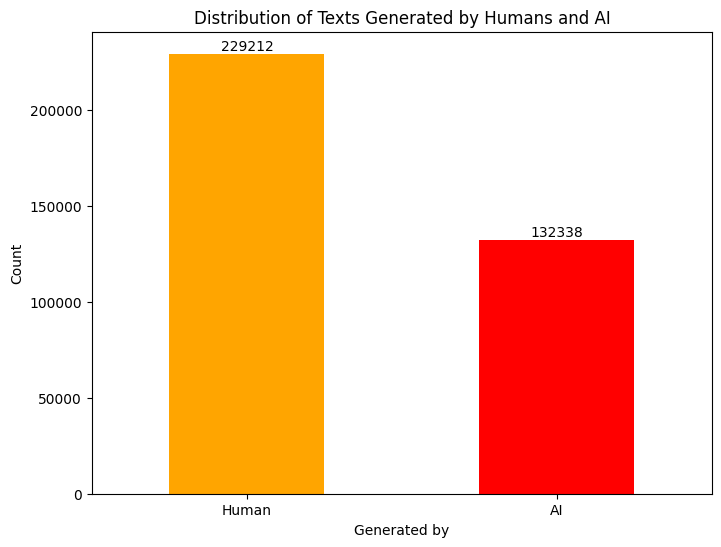

In [30]:
counts = df['generated'].value_counts()
# Plotting the counts
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['orange', 'red'])
plt.title('Distribution of Texts Generated by Humans and AI')
plt.xlabel('Generated by')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'AI'], rotation=0)
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

In [31]:
# Separate the dataset based on the class label
class_0 = df[df['generated'] == 0]
class_1 = df[df['generated'] == 1]

In [32]:
# Determine which class has fewer samples
min_samples = min(len(class_0), len(class_1))

In [33]:
min_samples

132338

In [34]:
# Randomly sample from each class to match the desired number of samples
class_0_sampled = class_0.sample(n=min_samples, random_state=42)
class_1_sampled = class_1.sample(n=min_samples, random_state=42)

In [35]:
# Combine the equal-sized subsets into a balanced dataset
balanced_df = pd.concat([class_0_sampled, class_1_sampled])

# Shuffle the rows of the balanced dataset
df1 = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
df1

,text,generated
0,main way majority people community get around ...,0
1,ralph waldo emerson american essayist philosop...,1
2,todays world important ke true becoming self s...,1
3,decision choosing career crucial one significa...,1
4,dear principal smith writing regarding decisio...,1
...,...,...
264671,challenge exploring venus author support idea ...,0
264672,advertising become integral part culture compa...,1
264673,facs facial action coding system new technolog...,0
264674,seeking multiple opinions making important dec...,1


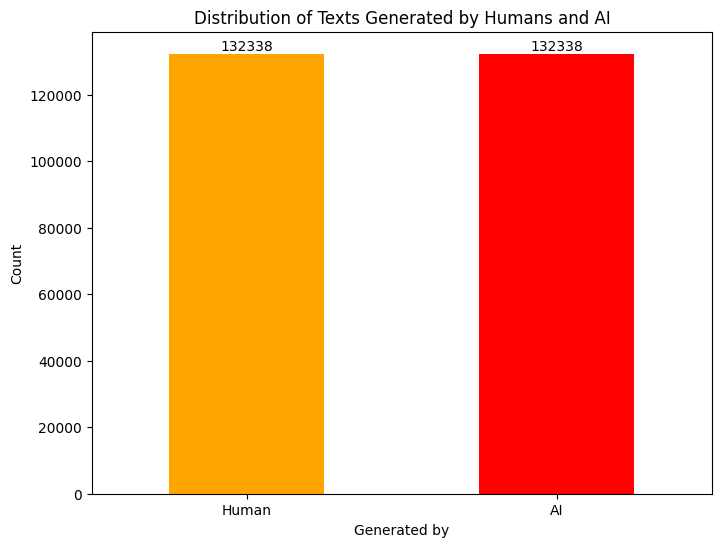

In [37]:
counts = df1['generated'].value_counts()
# Plotting the counts
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['orange', 'red'])
plt.title('Distribution of Texts Generated by Humans and AI')
plt.xlabel('Generated by')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'AI'], rotation=0)
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

In [38]:
# Convert text and generated columns to lists
texts = df1['text'].tolist()
generated = df1['generated'].tolist()

In [39]:
text = df1['text'] 

In [40]:
# Convert all elements to strings
texts = [str(text) for text in texts]

# Tokenize the concatenated text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [41]:
# Convert text to sequences
text_sequences = tokenizer.texts_to_sequences(text)
# Convert generated to a list of lists
generated_sequences = [[value] for value in generated]

In [42]:
# Pad sequences to ensure uniform length
max_length = 200
X_text = pad_sequences(text_sequences, maxlen=max_length)
X_generated = pad_sequences(generated_sequences, maxlen=max_length)

In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_text, generated, test_size=0.2, random_state=42)

In [44]:
# Build the model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          20881900  
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [45]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [46]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1708846780.398656     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1324/1324 [==============================] - 118s 84ms/step - loss: 0.1246 - accuracy: 0.9540 - val_loss: 0.0272 - val_accuracy: 0.9930
Epoch 2/10
1324/1324 [==============================] - 45s 34ms/step - loss: 0.0151 - accuracy: 0.9961 - val_loss: 0.0209 - val_accuracy: 0.9949
Epoch 3/10
1324/1324 [==============================] - 39s 30ms/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 0.0150 - val_accuracy: 0.9958
Epoch 4/10
1324/1324 [==============================] - 38s 29ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0110 - val_accuracy: 0.9970
Epoch 5/10
1324/1324 [==============================] - 37s 28ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0122 - val_accuracy: 0.9966
Epoch 6/10
1324/1324 [==============================] - 35s 27ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0132 - val_accuracy: 0.9964
Epoch 7/10
1324/1324 [==============================] - 35s 27ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0128 - val_accur

In [47]:
# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

1655/1655 [==============================] - 11s 6ms/step


In [50]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy Score: {accuracy}')

Accuracy Score: 0.9971286081305728


In [51]:
# Generate classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26585
           1       1.00      1.00      1.00     26351

    accuracy                           1.00     52936
   macro avg       1.00      1.00      1.00     52936
weighted avg       1.00      1.00      1.00     52936



In [52]:
# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC Score: {auc_roc}')

AUC-ROC Score: 0.9997681492984278


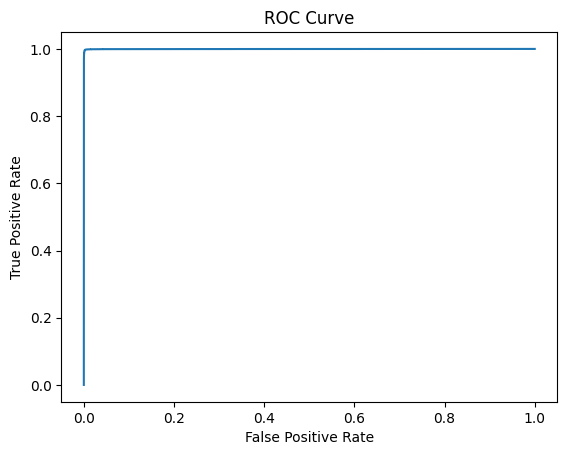

In [53]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [54]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[26532    53]
 [   99 26252]]


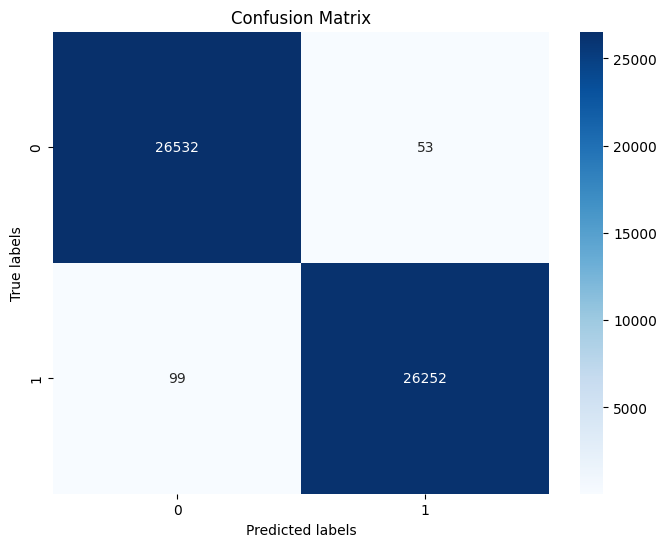

In [55]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [159]:
df3 = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

In [160]:
df3

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [161]:
df3.isna().sum()

id           0
prompt_id    0
text         0
dtype: int64

In [162]:
df3.duplicated().sum()

0

In [164]:
# Preprocess the text data in df3['text']
df3['text'] = df3['text'].apply(lambda x: x.lower())
df3['text'] = df3['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
df3['text'] = df3['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Tokenize the preprocessed text data
text_sequences_test = tokenizer.texts_to_sequences(df3['text'])

# Pad sequences to ensure uniform length
X_text_test = pad_sequences(text_sequences_test, maxlen=max_length)

# Predict labels for the preprocessed and tokenized test data
y_pred_test = model.predict(X_text_test)

# Convert predicted probabilities to binary labels
y_pred_binary_test = (y_pred_test > 0.5).astype(int)

1/1 [==============================] - 0s 25ms/step


In [165]:
# Add the predicted labels to the test dataframe
df3['generated'] = y_pred_test.flatten()

# Select only the 'id' and 'generated' columns
submission_df = df3[['id', 'generated']]

# Save the test dataframe with predicted labels to a CSV file
submission_df.to_csv('submission.csv', index=False)

In [166]:
submission_df

,id,generated
0,0000aaaa,0.996989
1,1111bbbb,0.996872
2,2222cccc,0.997073
